# XOR, linear separability, and decision boundaries

Author: Jeremy Dolan

In this notebook, we:
* Discuss the XOR function and its notoriety in neural networking's history
* Discuss linear separability and how multi-layer networks can solve linearly
  *in*separable problems
* Use our [neural network framework](neural_net_vanilla.py) to construct a
  multi-layer perceptron that learns XOR
* Analyze the trained network's parameters and visualize its decision
  boundaries to see how it implements a XOR circuit

NB: The neural network framework (and this analysis) is written without
numpy/pytorch/tensorflow/scikit-learn for educational purposes. It is wildly
inefficient.

In [1]:
# Our feed forward network framework:
from neural_net_vanilla import *
# Pyplot code for this notebook's illustrations:
import plots.xor

## XOR

XOR ("exclusive or") is a binary Boolean function; it maps 2 truth value
inputs (by convention: $0$ for false, $1$ for true) to one truth value output:

$$f : \{0,1\}^2 → \{0,1\}$$

The _input space_ for a binary Boolean function consists of 2 inputs with 2
possible values, giving us $2^2 = 4$ points: $(0,0)$, $(0,1)$, $(1,0)$, and
$(1,1)$. Each of those $2^2$ input pairs can independently map to 2 possible
output values, for a total of $2^{2^2} = 16$ possible functions. XOR is the
name we give to the function that maps points $(0,1)$ and $(1,0)$ to true, and
points $(0,0)$ and $(1,1)$ to false. It means, roughly: "One or the other, _but
not both_."

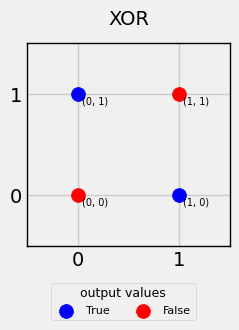

In [2]:
plots.xor.plot_binary_Boolean_input_space_with_XOR_output()

## Linear separability

As Marvin Minsky and Seymour Papert infamously underscored (_Perceptrons_,
1969), a single layer neural network can only be made to fit linearly separable
data: that is, data for which a single, straight line can separate two classes
of interest. For example, "OR" (inclusive or) is linearly separable: it is true
for three of the four points in our Boolean input space (the points where one
or the other or both inputs are true), and we can draw a straight line (a
"decision boundary") which separates these three points from the one point
where it is false ("OR classification," below, left).

XOR, however, is _not_ linearly separable. There is no line you can draw that
will partition the input space in such a way as to separate the input points
that map to true from the input points that map to false (below, right).

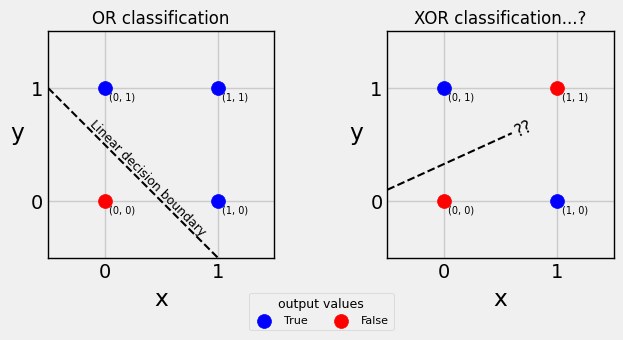

In [3]:
plots.xor.plot_linear_separation_OR_vs_XOR()

Minsky and Papert were correct that a *single-layer* neural network cannot
learn the XOR function, or any other linearly-inseparable function, no matter
how many nodes and connections it may have, or how we configure and train those
nodes and connections. As neither the computational power nor viable training
techniques for *multi-layer* networks was in sight, the pair argued that this
was a fundamental limitation for the connectionist approach to AI—thus
relegating neural networks to solving only toy problems, with no hope of
scaling to general-purpose learning.

> Many commentators credit Minsky and Papert's criticisms with playing a large
> role in the shift away from neural network research (and a decline in funding
> for AI in general) in the 1970s and early 1980s, although it seems this
> causal claim may be largely mythologized: see Olazaran (1996) "[A
> Sociological Study of the Official History of the Perceptrons
> Controversy][1]," and Liu (2024) "[The Perceptron Controversy][2]".

[1]: https://journals.sagepub.com/doi/abs/10.1177/030631296026003005
[2]: https://yuxi-liu-wired.github.io/essays/posts/perceptron-controversy/#ref-olazaranHistoricalSociologyNeural1991

Neural networks are no longer limited to a single layer (and indeed can be
hundreds of layers deep) thanks to Moore's Law, and the successful application
of backpropagation and gradient descent for training. But how does adding
additional layers allow a network to do what a single layer cannot, namely,
create non-linear decision boundaries in order to model linearly-inseparable
functions.

Roughly, when additional layers are added, a linearly-inseparable problem can
be broken down into linearly-separable steps. To help visualize this, we will
construct a two-layer network and analyze how it learns XOR.

# Implementation

Now we construct and train a network so that it learns the XOR function.

### Activation and loss function choice
Since we are working with binary values and, in effect, modeling Boolean
algebra, sigmoid is a natural choice for the activation function throughout our
network. Sigmoid squashes its input between 0 and 1, and we can interpret its
proximity to 0 or 1 as corresponding to the probability of the input belonging
to the false (0) or true (1) class for some Boolean operation, as those are
are ultimately the only values relevant when modeling a Boolean function.
 
Likewise, log loss is a natural choice for the loss function on our network's
output, as it is designed for probabilistic outputs of a binary classification
— which is what the sigmoid function produces.

Graphs of the functions we'll use:

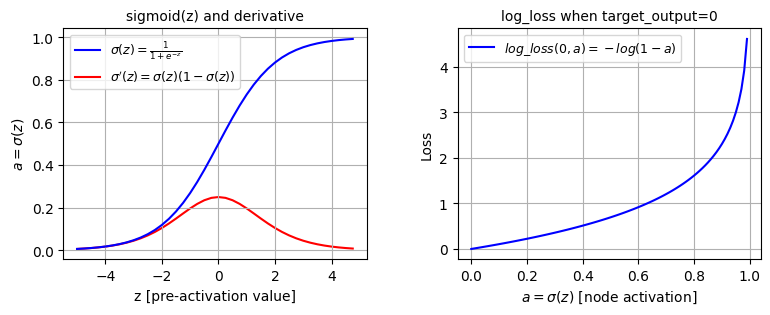

In [4]:
plots.xor.plot_functions(sigmoid, sigmoid_derivative, log_loss)

### Initialization

Initialize a network with the bare minimum depth (two layers) and breadth (two
hidden nodes, one output node) to implement XOR.

In [5]:
xor_net = Net(inputs=2, shape=[2, 1], activation_fxs=[sigmoid]*2, loss_fx=log_loss)
xor_net.show_params()

layer 1, node 1, node.weights=[-0.24007777398521937, -0.13431973138145759] node.bias=0.0
layer 1, node 2, node.weights=[-0.1776440885660599, 0.2085518320539621] node.bias=0.0
layer 2, node 1, node.weights=[0.1204244341442691, 0.21187263739855006] node.bias=0.0


### Training

Our training data is simply all four input/output pairs for the XOR function:

In [6]:
# Our framework's training data format uses key 'x' for input and 'y' for true output
xor_training = (
    {'x': (0,0), 'y': (0)},
    {'x': (1,0), 'y': (1)},
    {'x': (0,1), 'y': (1)},
    {'x': (1,1), 'y': (0)},
)

Train the network, using batch gradient decent:

In [7]:
# high learning rate helps get us off initial plateau, not so high as to overshoot
xor_net.batch_train(training_data=xor_training, epochs=5_000, learning_rate=1.75)
xor_net.show_params()

epoch    1, loss 0.6964217422661341
epoch 1000, loss 0.6931012359668144
epoch 2000, loss 0.012885448207885859
epoch 3000, loss 0.0038009696993876307
epoch 4000, loss 0.0022144839848915916
epoch 5000, loss 0.0015597134171584284
layer 1, node 1, node.weights=[-7.177880787139599, 7.4549991333883225] node.bias=3.573027623013989
layer 1, node 2, node.weights=[-7.548069958514174, 7.338672637740475] node.bias=-3.8822059980074157
layer 2, node 1, node.weights=[-13.713143709298807, 14.179080237272379] node.bias=6.548361605350596


### Prediction

The loss from the final training epoch suggests the network is adequately
trained, but we can verify its predictions for the relevant inputs:

In [8]:
for training_case in xor_training:
    x = training_case['x']                  # input
    y = training_case['y']                  # correct output
    y_hat = xor_net.forward(x)[-1][0]       # predicted output
    binary_y_hat = 0 if y_hat < 0.5 else 1  # categorical output

    print(f'{x[0]} XOR {x[1]} --prediction--> {binary_y_hat}', end='   ')
    if y == binary_y_hat:
        print(f'correct! \u2705   ({y_hat=:f}, loss={log_loss(y, y_hat):f})')
    else:
        print(f'miss! \u274C   ({y_hat=:f}, loss={log_loss(y, y_hat):f})')

0 XOR 0 --prediction--> 0   correct! ✅   (y_hat=0.001495, loss=0.001496)
1 XOR 0 --prediction--> 1   correct! ✅   (y_hat=0.997945, loss=0.002057)
0 XOR 1 --prediction--> 1   correct! ✅   (y_hat=0.998615, loss=0.001386)
1 XOR 1 --prediction--> 0   correct! ✅   (y_hat=0.001297, loss=0.001298)


# Analysis

Now that we have successfully trained the network to model XOR, we can
investigate how it organized itself to do so. Let's first consider just one of
our hidden nodes, and look at its parameters:

In [9]:
node = xor_net.layers[0].nodes[0]

print(f'weights: {node.weights}')
print(f'bias: {node.bias}')

weights: [-7.177880787139599, 7.4549991333883225]
bias: 3.573027623013989


Recall the process of calculating a node's activation: each weight $w_i$ is
multiplied by its corresponding input $x_i$, these weighted inputs are summed
together, and then the bias $b$ is added to get our "pre-activation" value $z$.

$$z = \Sigma_{i} w_{i} x_i + b$$

Finally, we feed $z$ into our activation function (sigmoid, $\sigma$)
to get the node's final activation $a$.

$$a = \sigma(z)$$

Also recall that the sigmoid function (graphed above) squashes all positive
values into the range (0.5, 1)—all of which we will classify as true—and all
negative values into the range (0, 0.5)—all of which we will classify as false.
* positive $z$ → $a$ > 0.5 → "true"
* negative $z$ → $a$ < 0.5 → "false"

So we can sufficiently approximate the classification just by determining
whether $z$ is positive or negative.

<!-- Could dynamically analyze the following... -->

Since our node has only two binary inputs, it's simple enough to think through
which input pairs should give us a positive $z$ and which should give us a
negative $z$ for the case from above:
```yaml
    weights: [-7.177880787139599, 7.4549991333883225]
    bias: 3.573027623013989
```
First note that the bias is positive, so all else being equal, $z$ will be
positive. Note also the weights are approximately equal in magnitude, but with
opposite signs. So if both inputs are $1$, the weighted inputs will roughly
cancel out and the bias will dominate, giving us positive $z$. All the more so
if only the second input is $1$, because its positive weight will be added into
$z$. And of course if both inputs are $0$, then $z = b$ and is positive. So the
only way for $z$ to be negative is if just the first input is $1$, and its
negative weight overcomes the positive bias.

In sum, our inspection implies that this node draws its linear decision
boundary so as to separate the point $(1,0)$, classifying it as false, from the
other three Boolean inputs, which it classifies as true. But let's now verify
this in a more automated way.

### Visualizing decision boundaries

Our network counts as a model of XOR when it correctly categorizes the four
Boolean input points. But we can also input *other points* as well, and see how
it categorizes them. And if we plot enough points, we can reveal just where the
model's categorizations switch from true to false—that is, we can visualize the
decision boundary that a node or model has learned.

<!--
While in general decision boundaries can be curved, we know from our earlier
discussion that the decision boundary for a single node will be a straight line.
-->

First we need a function to evaluate a node (or our entire model) for all
inputs from a N x N grid points in input space:

In [10]:
def meshgrid_eval(method, start, stop, N):
    '''evaluate `method` on an N x N grid of evenly-spaced points spanning [start, stop] along both axes.'''
    step_size = (stop-start)/N
    N += 1 # make the range inclusive on both ends

    meshgrid = []
    for i in range(N):
        x1 = start + (i*step_size)
        row = []
        for j in range(N):
            x2 = start + (j*step_size)
            row.append(method((x1, x2)))
        meshgrid.append(row)
    return meshgrid

Then we call the function, which will activate the node using each point in our
coordinate grid as input, and plot the output. We specify the grid so that it
extends over an area surrounding the four original inputs (say, from -0.5 to
1.5 along both axes), with 100 points in each direction, for 100x100=10,000
total points to sample.

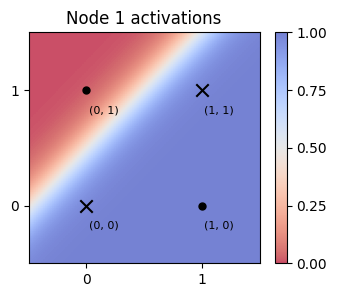

In [11]:
# sample 100x100 points between -0.5 and 1.5 and save the node's activations
meshgrid_node1 = meshgrid_eval(xor_net.layers[0].nodes[0].activate, start=-0.5, stop=1.5, N=100)

# plot the resulting activations as a gradient over the input space
plots.xor.plot_meshgrid(meshgrid_node1, 'Node 1 activations')

As we expected, the decision boundary is linear, separating $(0,1)$ from the
other three points.

In the same way, we can also plot the decision boundary for the other hidden
node, and for the network as a whole:

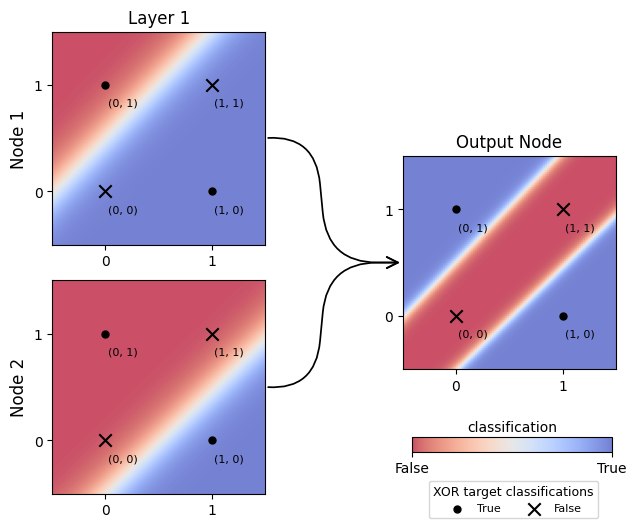

In [12]:
meshgrid_node2  = meshgrid_eval(xor_net.layers[0].nodes[1].activate, start=-0.5, stop=1.5, N=100)
meshgrid_xornet = meshgrid_eval(lambda inputs: xor_net.forward(inputs)[-1][0], start=-0.5, stop=1.5, N=100)
plots.xor.plot_net_meshgrids(node1grid=meshgrid_node1, node2grid=meshgrid_node2, outputgrid=meshgrid_xornet)

🚧 🚧 🚧 notebook unedited starting here 🚧 🚧 🚧  
Here we see the activations over input space for all of the nodes in our
network, and we can finally discuss how a multi-layer network draws non-linear
decision boundaries (such as the decision boundary of our output node, depicted
above).

In our network, node 1 learns a (linear) decision boundary that separates one
point from the other three, and node 2 learns a (linear) decision boundary that
separates out the diagonally opposite point. Together, those two points will
constitute either the 'true' or 'false' class for XOR.

By isolating out each of that pair of points in layer 1, layer 2 can then
conjoin, disjoin, and negate (as needed) those layer 1 outputs. And
conjunction, disjunction, and negation are all linearly separable functions.

The result, depicted as the gradient on the "Output Node," above, is a
layering/stacking/joining of the decision boundaries from layer 1.

One thing to note is that it doesn't matter *how* the nodes in layer 1 end up
carving out the two points (i.e., it doesn't matter which points get a ~0 or ~1
activation), because downstream layers can simply negate the value to 'flip' it.

It also doesn't matter if layer one isolates out each of the points in input
space that are true for XOR, or are false for XOR. If we train a new network,
we can easily find one which isolates out the other set of points:  
🚧 🚧 🚧 🚧 🚧 🚧

In [13]:
xor_alt = Net(inputs=2, shape=[2, 1], activation_fxs=[sigmoid]*2, loss_fx=log_loss)
xor_alt.batch_train(training_data=xor_training, epochs=5_000, learning_rate=1.75)
xor_alt.show_params()

epoch    1, loss 0.6962019108749871
epoch 1000, loss 0.02666935672827604
epoch 2000, loss 0.004587053847391903
epoch 3000, loss 0.002475299262388743
epoch 4000, loss 0.0016902765538370362
epoch 5000, loss 0.0012818391788446124
layer 1, node 1, node.weights=[6.16112162439482, 6.159648421283137] node.bias=-9.515953878675996
layer 1, node 2, node.weights=[-7.738896530079592, -7.729212724950222] node.bias=3.256916229227493
layer 2, node 1, node.weights=[-14.800456783209414, -14.566271045050144] node.bias=7.225800227209095


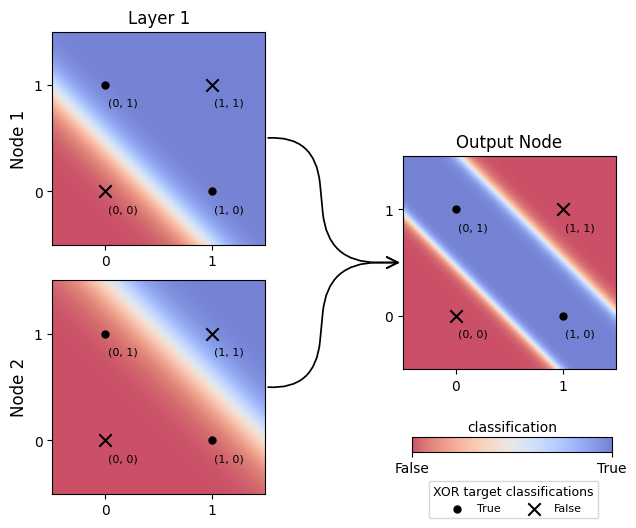

In [14]:
meshgrid_alt1 = meshgrid_eval(xor_alt.layers[0].nodes[0].activate, start=-0.5, stop=1.5, N=100)
meshgrid_alt2  = meshgrid_eval(xor_alt.layers[0].nodes[1].activate, start=-0.5, stop=1.5, N=100)
meshgrid_xoralt = meshgrid_eval(lambda inputs: xor_alt.forward(inputs)[-1][0], start=-0.5, stop=1.5, N=100)
plots.xor.plot_net_meshgrids(node1grid=meshgrid_alt1, node2grid=meshgrid_alt2, outputgrid=meshgrid_xoralt)

In this training run, we can see that layer 1 happened to select out the pair
of input points from the 'false' XOR class, $(0,0)$ and $(1,1)$. Per our
earlier discussion, this is a perfectly viable way to learn XOR for its domain
of 4 Boolean inputs.

However, the resulting network will generalize quite differently to inputs from
outside the training distribution (distribution shift). This can be seen
visually in the output node's decision boundary being rotated 90º from our
original trained network.

In [15]:
in_domain_point = (0, 1)
OOD_point = (-0.5, 0.5)
print(f'Agreement about in domain point {in_domain_point}:')
print(f'\txor_net:{xor_net.forward(in_domain_point)[-1][0]}\txor_alt:{xor_alt.forward(in_domain_point)[-1][0]}')
print(f'Disagreement about out of domain point {OOD_point}:')
print(f'\txor_net:{xor_net.forward(OOD_point)[-1][0]}\txor_alt:{xor_alt.forward(OOD_point)[-1][0]}')

Agreement about in domain point (0, 1):
	xor_net:0.9986154199336801	xor_alt:0.9988582558911349
Disagreement about out of domain point (-0.5, 0.5):
	xor_net:0.9986722117668926	xor_alt:0.0016320156847138142
